<a href="https://colab.research.google.com/github/revathys/CarPrice/blob/main/prompt_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

The objective of this project is to create an analytic model that predicts the resale value of cars based on features like year, model, condition

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
# load the car data
cardata = pd.read_csv('data/vehicles.csv')
#understanding the data
cardata.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
cardata.shape

(233066, 18)

In [5]:
cardata.describe()

,id,price,year,odometer
count,2.330660e+05,2.330660e+05,232209.000000,2.307010e+05
mean,7.311731e+09,7.555470e+04,2011.197899,9.867410e+04
std,4.530603e+06,1.060528e+07,9.498140,2.290955e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308332e+09,5.999000e+03,2008.000000,3.723800e+04
50%,7.313258e+09,1.399500e+04,2013.000000,8.500000e+04
75%,7.315386e+09,2.599900e+04,2017.000000,1.344080e+05
max,7.317024e+09,3.024942e+09,2022.000000,1.000000e+07


In [6]:
cardata.dtypes

,0
id,int64
region,object
price,int64
year,float64
manufacturer,object
model,object
condition,object
cylinders,object
fuel,object
odometer,float64


In [7]:
# find number of null fields
cardata.isna().sum()

,0
id,0
region,0
price,0
year,857
manufacturer,9973
model,2761
condition,93478
cylinders,96856
fuel,1110
odometer,2365


In [8]:
#missing values percentage
((cardata.isna().sum()/len(cardata))*100).sort_values(ascending=False).head(10)

,0
size,72.020801
cylinders,41.557327
condition,40.107952
VIN,38.001253
drive,31.107497
paint_color,30.555293
type,22.365768
manufacturer,4.279045
title_status,2.062935
model,1.184643


In [9]:
#find unique value counts for categorical values
categorical_columns = cardata.select_dtypes(include=['object']).columns
print("Top of categorical features with unique values")
cardata.select_dtypes(include=['object']).nunique().sort_values(ascending=False).head(10)



Top of categorical features with unique values


,0
VIN,70573
model,20336
region,236
manufacturer,42
state,34
type,13
paint_color,12
cylinders,8
title_status,6
condition,6


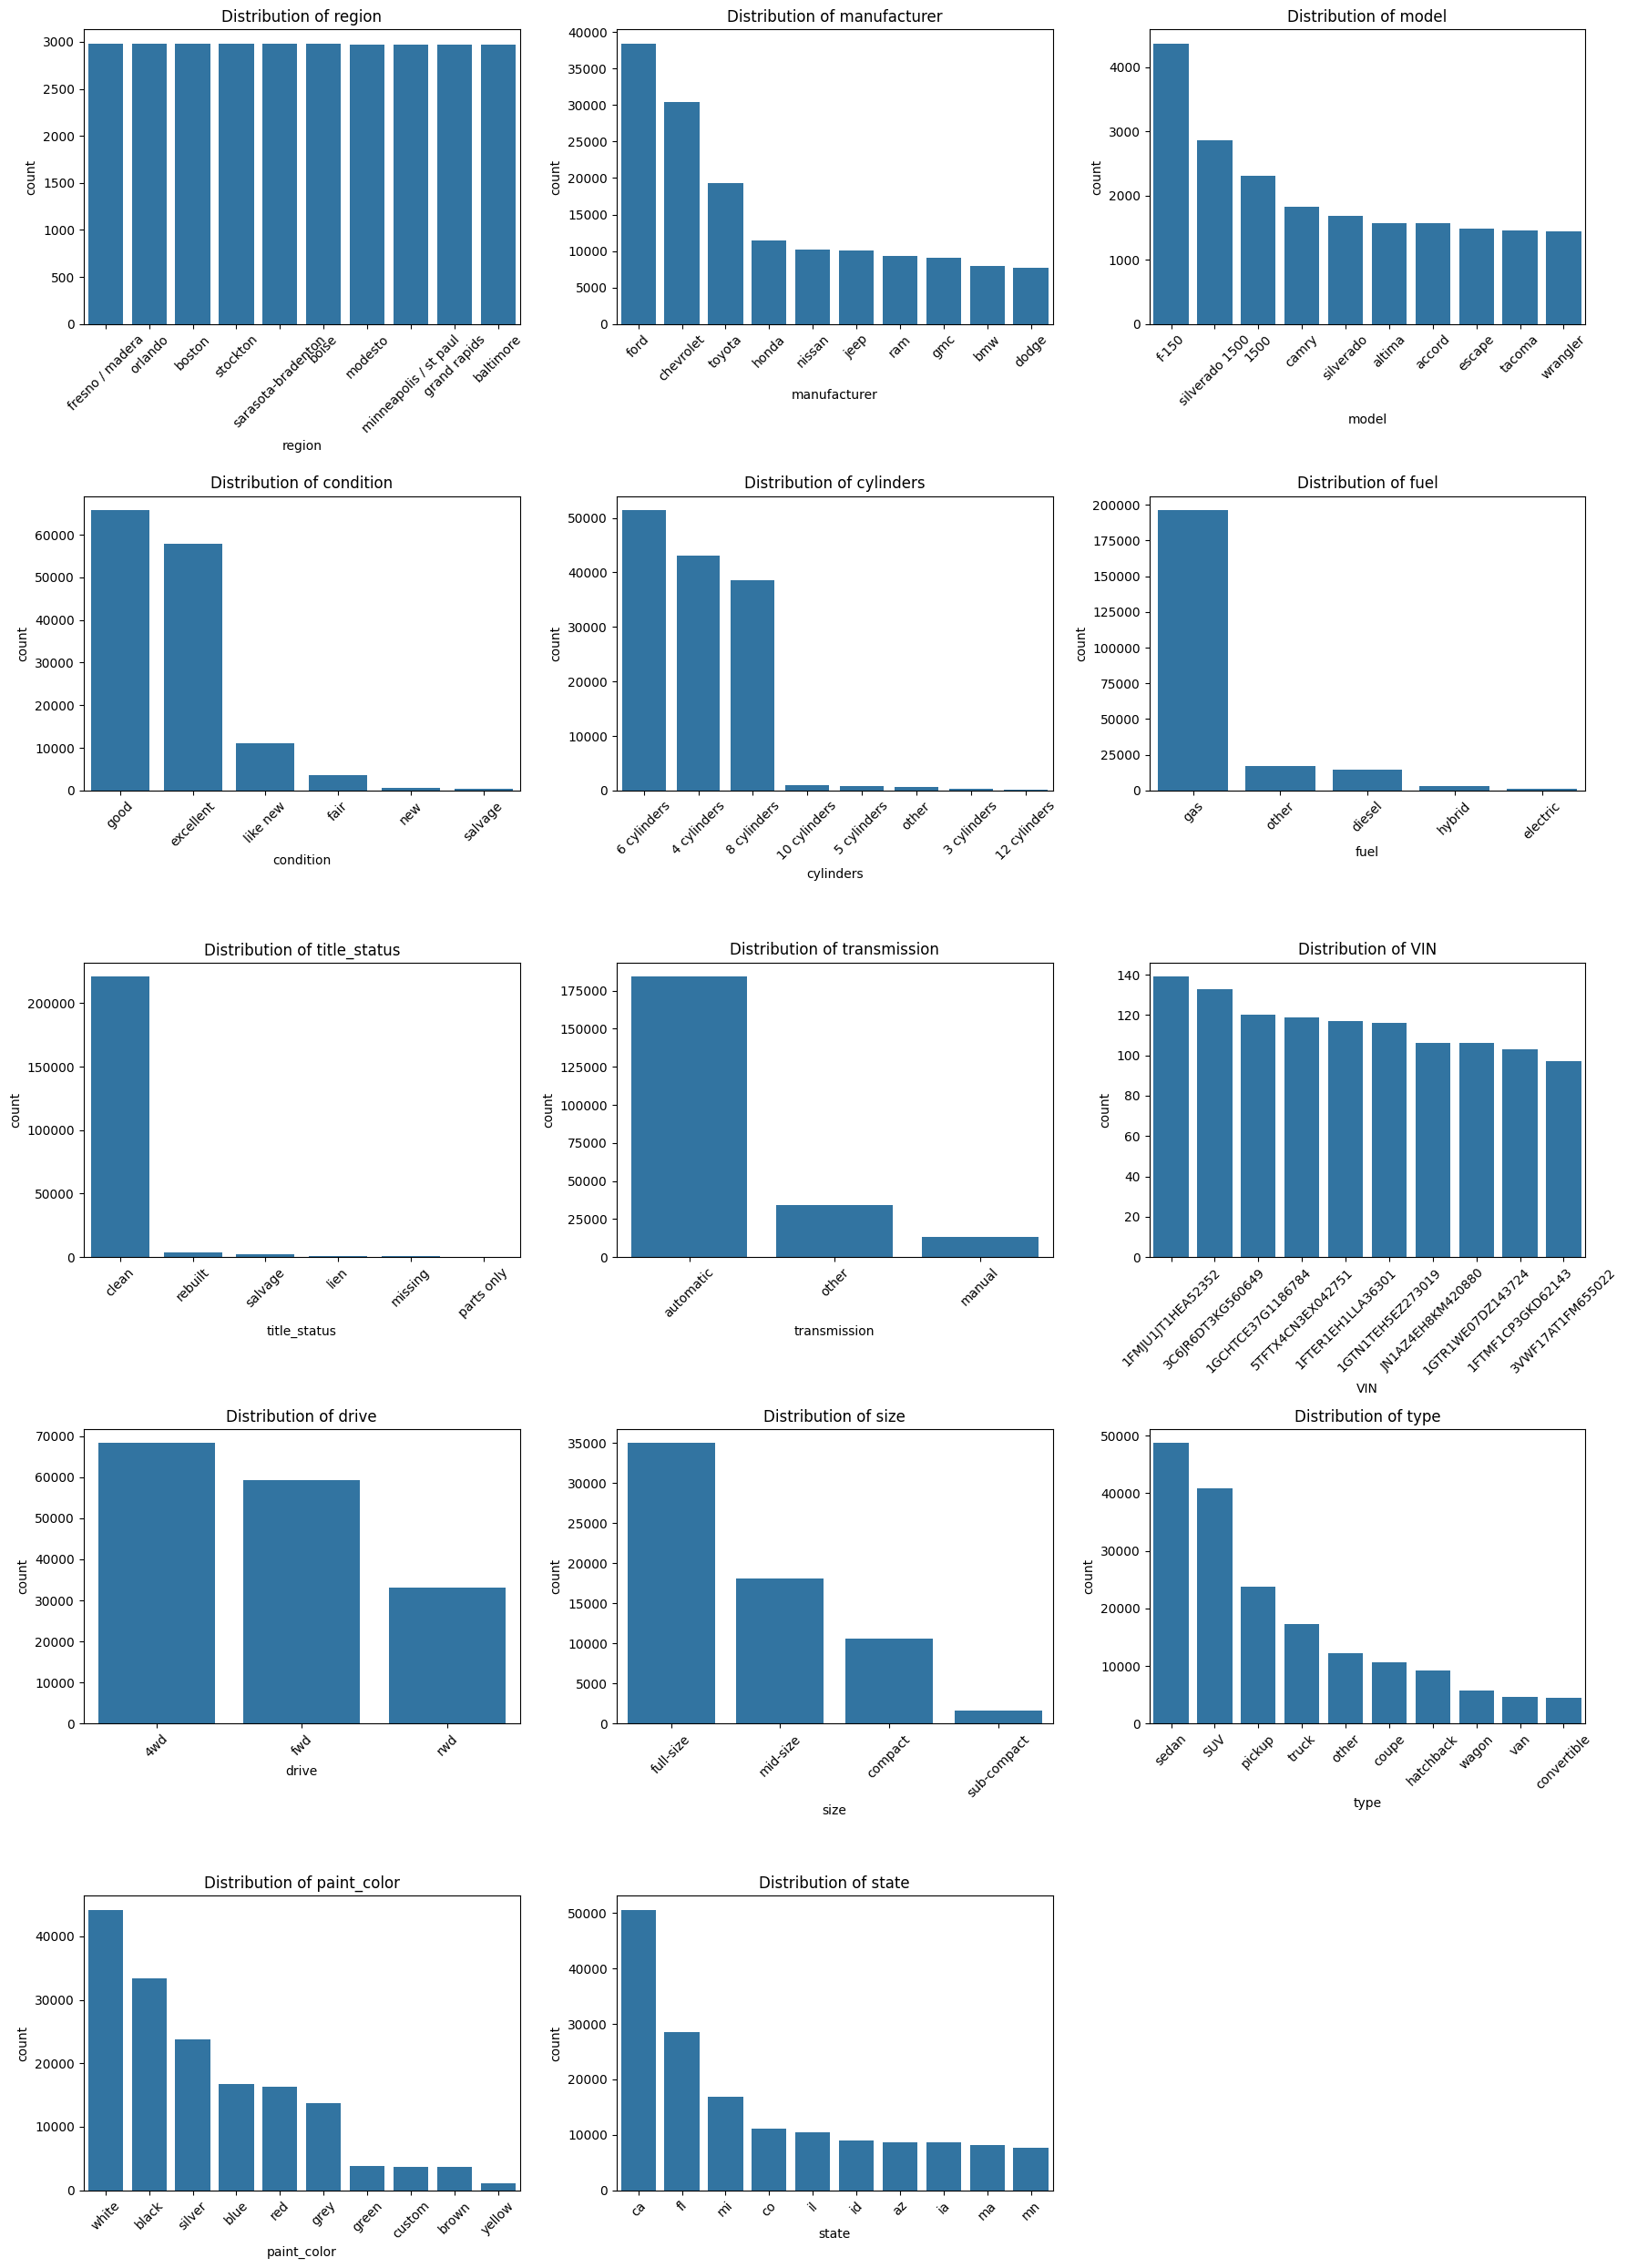

In [10]:
#plot count distribution of categorical values
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5*n_rows))

axes = axes.flatten()  # make 2D array of axes into 1D for easy looping

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=cardata, ax=axes[i], order=cardata[col].value_counts().index[:10])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots if 14 doesn't fit perfectly into 3-column grid
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

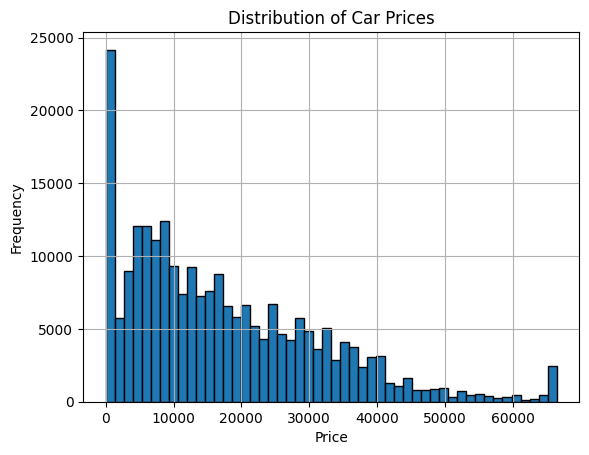

In [11]:
#plot distribution of car prices
import matplotlib.pyplot as plt
import seaborn as sns

cardata['price'].clip(upper=cardata['price'].quantile(0.99)).hist(bins=50, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices')
plt.show()





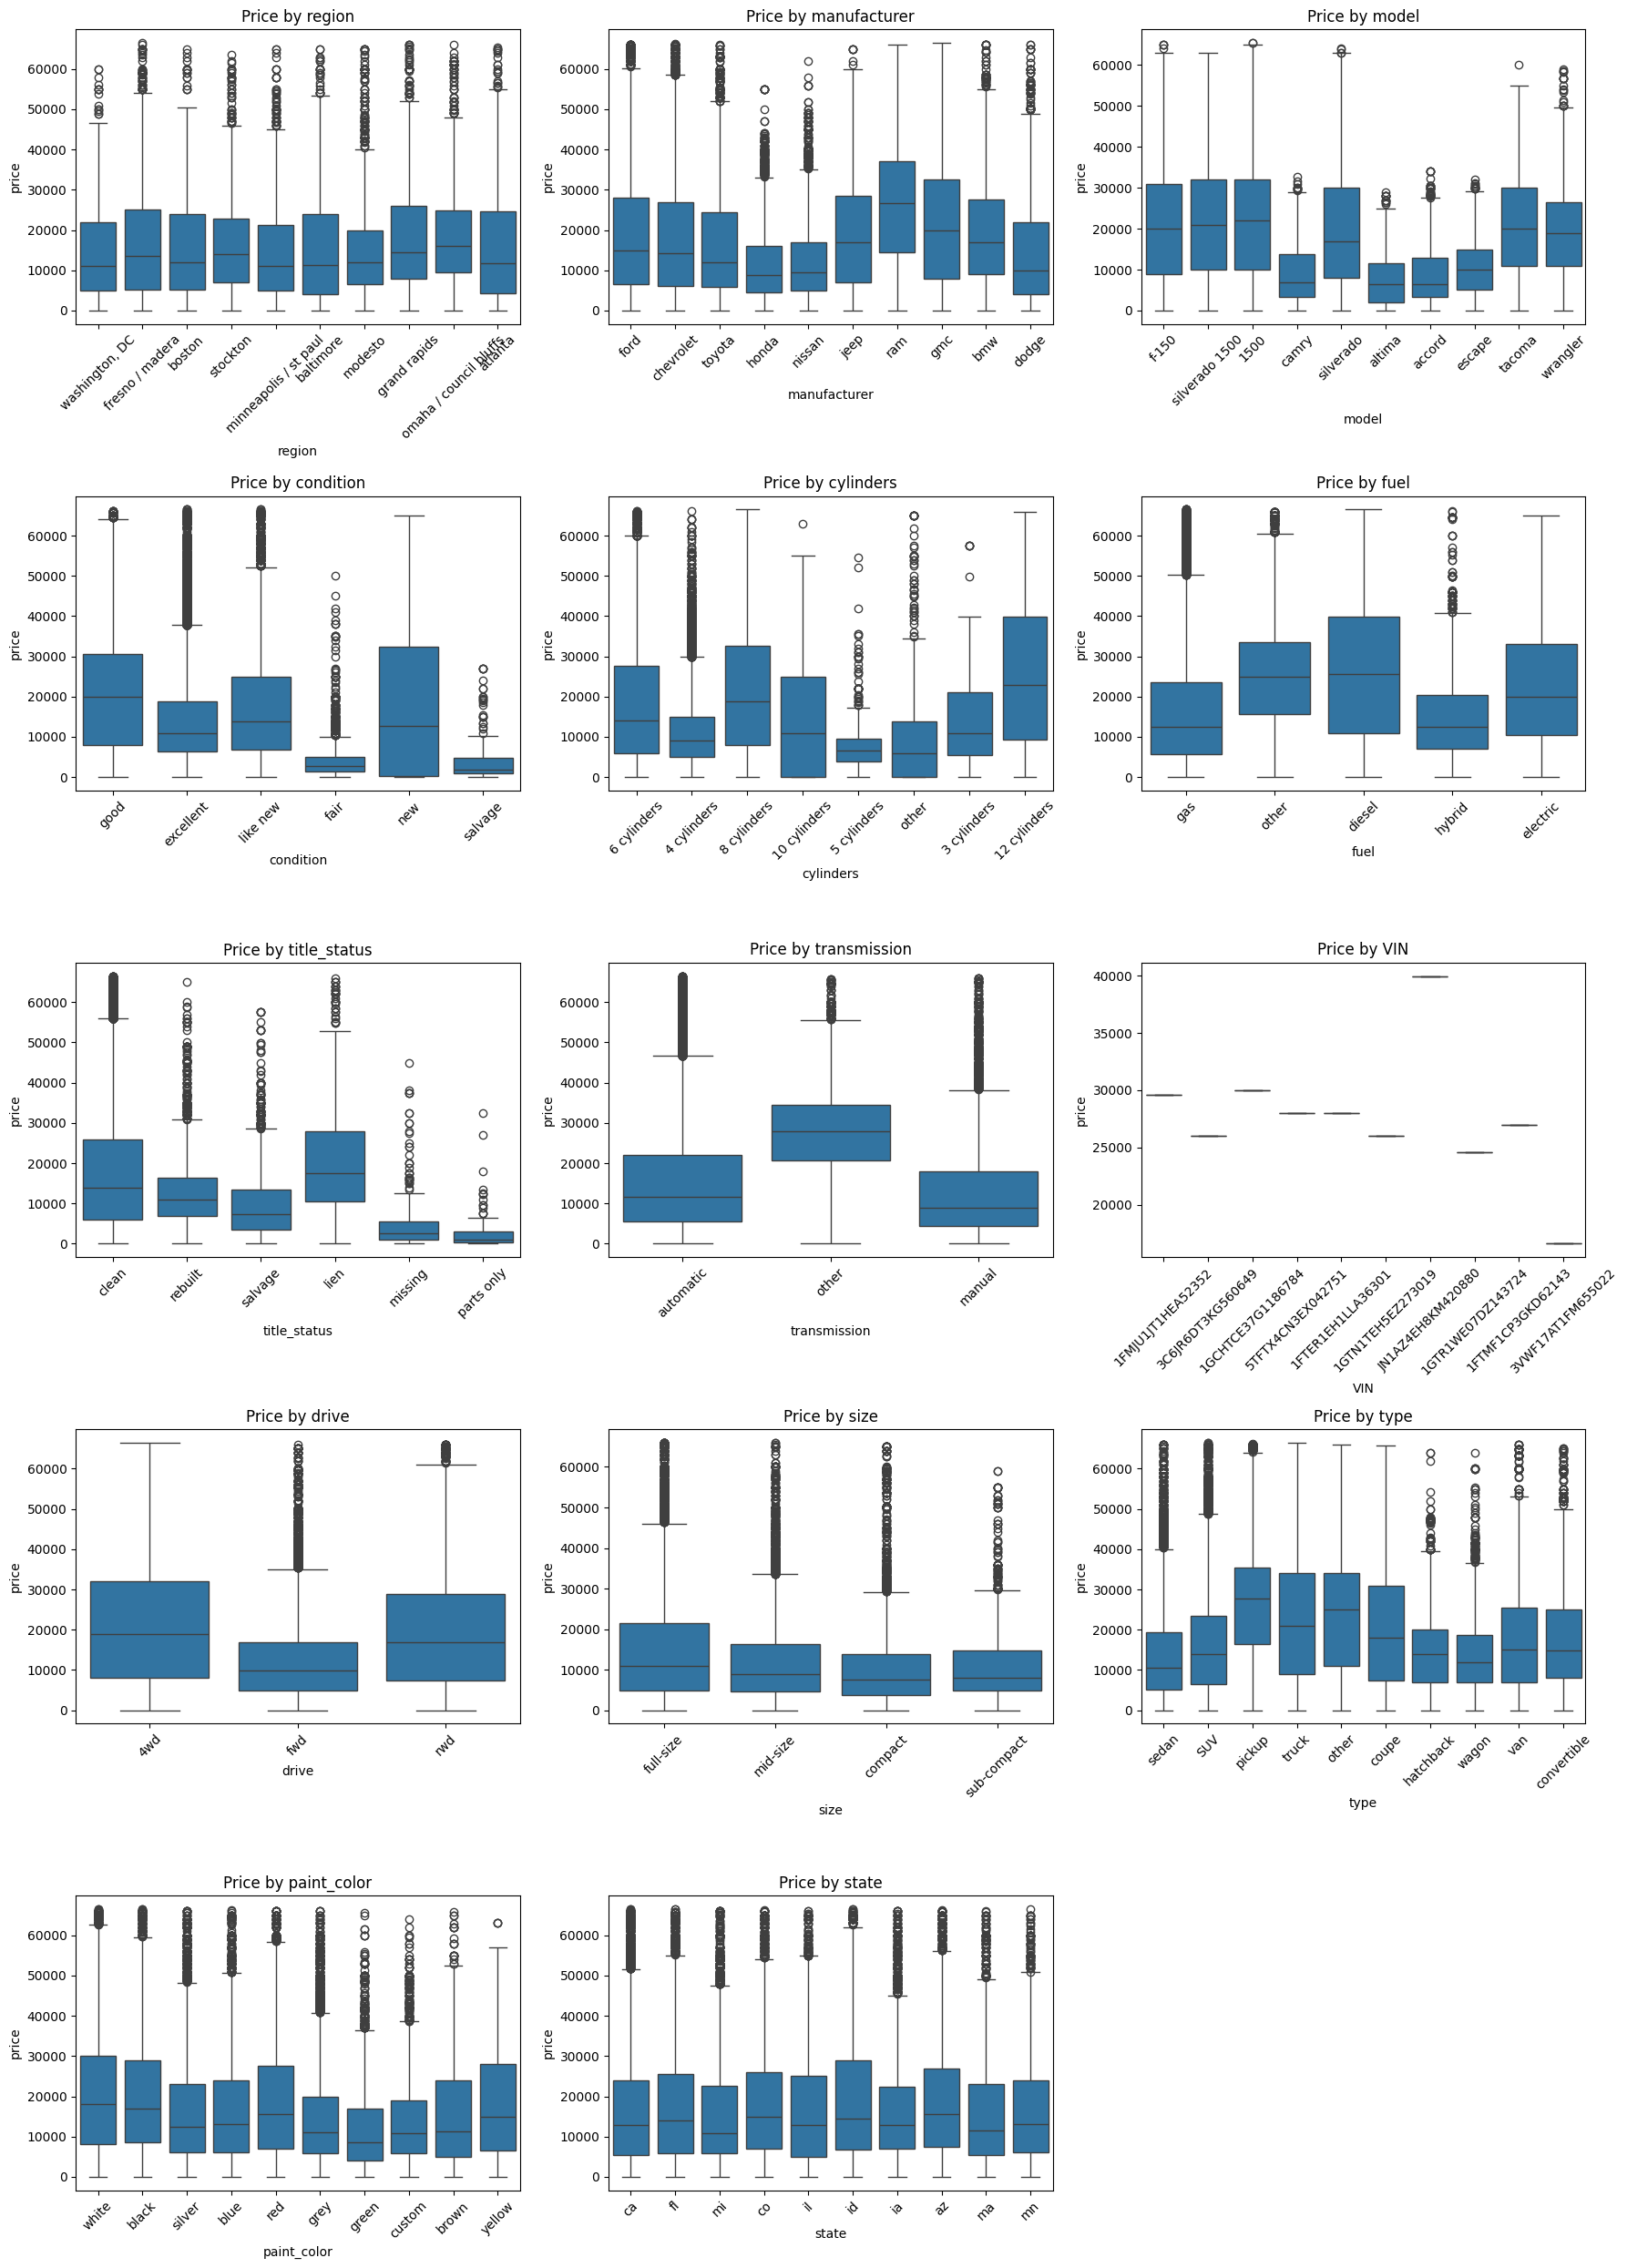

In [12]:
#plot price vs categorical features
cardata_filtered = cardata[cardata['price'] <= cardata['price'].quantile(0.99)]
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y="price", data=cardata_filtered, ax=axes[i],
                order=cardata_filtered[col].value_counts().index[:10])  # limit to top 10 categories
    axes[i].set_title(f"Price by {col}")
    axes[i].tick_params(axis='x', rotation=45)

# remove unused plots if grid > number of categorical columns
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

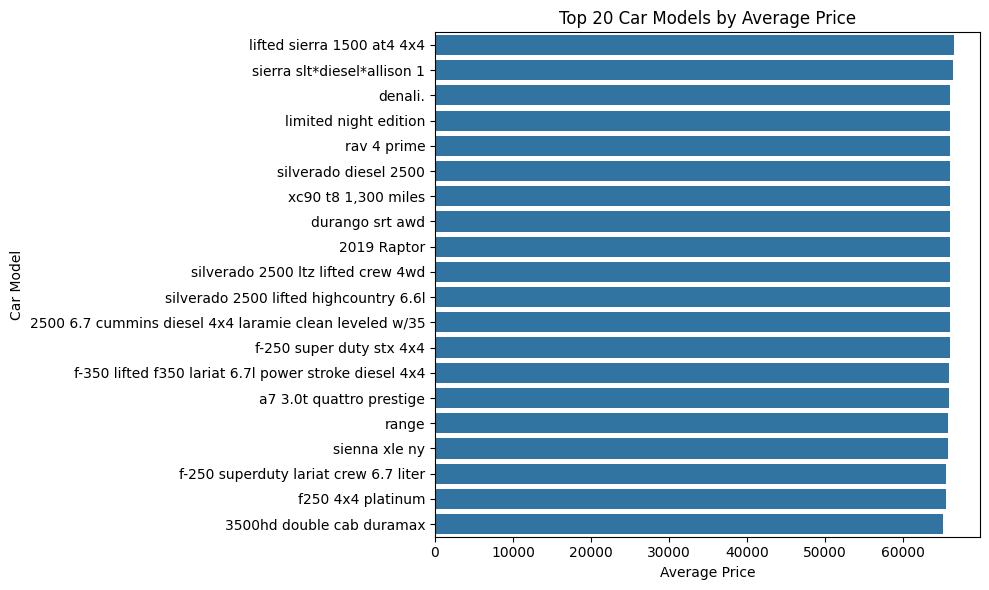

In [13]:
# Calculate average price for each car model
avg_prices_by_car = cardata_filtered.groupby('model')['price'].mean().sort_values(ascending=False)

# Plot top N car models by average price
n = 20  # Number of top car models to plot
top_car_models = avg_prices_by_car.head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Models by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

None


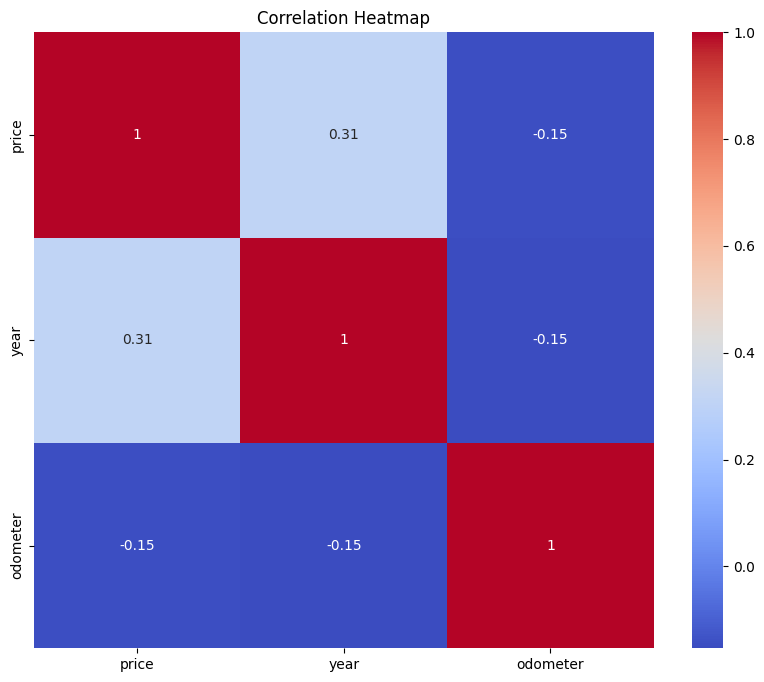

In [14]:
#plot heat map for numerical features
print(cardata_filtered.index.name)
correlation_matrix = cardata_filtered.select_dtypes(include=['number']).drop('id', axis =1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [15]:
#filter top 99 percent of price data
cardata_filtered = cardata[cardata['price'] <= cardata['price'].quantile(0.99)]
#drop features with too many missing data and too many unique categories
columns_to_drop = ['id','size','cylinders','condition','VIN','drive','paint_color','region','state']
#low_cardinality_columns = ['fuel','transmission','title_status']
#high_cardinality_columns = ['model','manufacturer','type']
cardata_filtered = cardata_filtered.drop(columns=columns_to_drop).dropna()
cardata_filtered.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,gas,57923.0,clean,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,gas,71229.0,clean,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,gas,19160.0,clean,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,gas,41124.0,clean,other,pickup
31,15000,2013.0,ford,f-150 xlt,gas,128000.0,clean,automatic,truck


In [16]:
cardata_filtered.select_dtypes(include=['object']).nunique().sort_values(ascending=False).head()


,0
model,13313
manufacturer,41
type,13
title_status,6
fuel,5


In [17]:
top_models = cardata_filtered['model'].value_counts().nlargest(20).index
top_manufacturer = cardata_filtered['manufacturer'].value_counts().nlargest(20).index
cardata_filtered['model'] = cardata_filtered['model'].where(cardata_filtered['model'].isin(top_models), 'Other')
cardata_filtered['manufacturer'] = cardata_filtered['manufacturer'].where(cardata_filtered['manufacturer'].isin(top_manufacturer), 'Other')
cardata_filtered['age']= 2025 - cardata_filtered['year']
#cardata_filtered = cardata_filtered.drop(columns=['year'])
cardata_filtered.head()


,price,year,manufacturer,model,fuel,odometer,title_status,transmission,type,age
27,33590,2014.0,gmc,Other,gas,57923.0,clean,other,pickup,11.0
28,22590,2010.0,chevrolet,silverado 1500,gas,71229.0,clean,other,pickup,15.0
29,39590,2020.0,chevrolet,Other,gas,19160.0,clean,other,pickup,5.0
30,30990,2017.0,toyota,Other,gas,41124.0,clean,other,pickup,8.0
31,15000,2013.0,ford,Other,gas,128000.0,clean,automatic,truck,12.0


In [18]:
cat_col = cardata_filtered.select_dtypes(include=['object']).columns
cardata_filtered.select_dtypes(include=['object']).nunique().sort_values(ascending=False).head()


,0
manufacturer,21
model,21
type,13
title_status,6
fuel,5


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [19]:
#prepare train and test data
X = cardata_filtered.drop(columns = ['price'])
y = cardata_filtered['price']
num_colums = X.select_dtypes(include=['number']).columns
cat_colums = X.select_dtypes(include=['object']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
#scale numeric values and encode categorical values
transformer = ColumnTransformer([
    ('num', StandardScaler(), num_colums),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_colums)
])

param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 10)
}
#create pipeline for model
regression_pipeline = Pipeline([('transformer',transformer),('regressor',Ridge())])
grid = GridSearchCV(estimator=regression_pipeline,param_grid=param_grid,cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error')
# Fit model
grid.fit(X_train, y_train)
print("Best alpha:", grid.best_params_['regressor__alpha'])
print("Best CV score (MSE):", -grid.best_score_)
print("Best CV RMSE:", np.sqrt(-grid.best_score_))

best_model = grid.best_estimator_

Best alpha: 10.0
Best CV score (MSE): 108842419.94557881
Best CV RMSE: 10432.757063479376


In [21]:


# Predictions
y_pred_regression = best_model.predict(X_test)



In [22]:
#Get baseline price
intercept = grid.best_estimator_.named_steps['regressor'].intercept_
print("Baseline price (intercept):", intercept)

Baseline price (intercept): 21867.139218622382


cat__type_hatchback       -6226.841512
cat__type_pickup           5967.485959
cat__manufacturer_audi     5365.011848
cat__model_wrangler        5283.600676
cat__type_truck            5107.419044
cat__type_sedan           -5068.530250
cat__type_wagon           -4525.331132
cat__transmission_other    4520.999772
cat__manufacturer_kia     -4328.941526
cat__manufacturer_lexus    4294.048725
dtype: float64


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [24]:
# Evaluate
mse_regression = mean_squared_error(y_test, y_pred_regression)
print(f"Mean Squared Error: {mse_regression:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse_regression):.2f}")

print(f"Mean Price for cars: {cardata_filtered['price'].mean():.2f}")

Mean Squared Error: 108736091.09
Root Mean Squared Error: 10427.66
Mean Price for cars: 17905.55


In [28]:
# Check what features matter most
feature_names = (
    best_model.named_steps['transformer']
    .get_feature_names_out()
)

#feature_names = best_model.named_steps['poly'].get_feature_names_out(feature_names)

coefficients = best_model.named_steps['regressor'].coef_

importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)
print(importance.head(10))

cat__type_hatchback       -6226.841512
cat__type_pickup           5967.485959
cat__manufacturer_audi     5365.011848
cat__model_wrangler        5283.600676
cat__type_truck            5107.419044
cat__type_sedan           -5068.530250
cat__type_wagon           -4525.331132
cat__transmission_other    4520.999772
cat__manufacturer_kia     -4328.941526
cat__manufacturer_lexus    4294.048725
dtype: float64


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.